# KAN_fast_fast KAN网络的近似快速实现
使用github @ZiyaoLi 的KAN网络实现 比KNA_fast快3倍左右

### 使用高斯径向基函数来近似 B 样条函数
这样做的基本原理是，这些函数非常接近 B 样条函数（直至线性变换），并且非常容易计算（只要网格是均匀的）。

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import *

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, time_benchmark=False):
        if not time_benchmark:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim, out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class AttentionWithFastKANTransform(nn.Module):
    
    def __init__(
        self,
        q_dim: int,
        k_dim: int,
        v_dim: int,
        head_dim: int,
        num_heads: int,
        gating: bool = True,
    ):
        super(AttentionWithFastKANTransform, self).__init__()

        self.num_heads = num_heads
        total_dim = head_dim * self.num_heads
        self.gating = gating
        self.linear_q = FastKANLayer(q_dim, total_dim)
        self.linear_k = FastKANLayer(k_dim, total_dim)
        self.linear_v = FastKANLayer(v_dim, total_dim)
        self.linear_o = FastKANLayer(total_dim, q_dim)
        self.linear_g = None
        if self.gating:
            self.linear_g = FastKANLayer(q_dim, total_dim)
        # precompute the 1/sqrt(head_dim)
        self.norm = head_dim**-0.5

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        bias: torch.Tensor = None,      # additive attention bias
    ) -> torch.Tensor:         

        wq = self.linear_q(q).view(*q.shape[:-1], 1, self.num_heads, -1) * self.norm     # *q1hc
        wk = self.linear_k(k).view(*k.shape[:-2], 1, k.shape[-2], self.num_heads, -1)    # *1khc
        att = (wq * wk).sum(-1).softmax(-2)     # *qkh
        del wq, wk
        if bias is not None:
            att = att + bias[..., None]

        wv = self.linear_v(v).view(*v.shape[:-2],1, v.shape[-2], self.num_heads, -1)     # *1khc
        o = (att[..., None] * wv).sum(-3)        # *qhc
        del att, wv

        o = o.view(*o.shape[:-2], -1)           # *q(hc)

        if self.linear_g is not None:
            # gating, use raw query input
            g = self.linear_g(q)
            o = torch.sigmoid(g) * o

        # merge heads
        o = self.linear_o(o)
        return o


## 执行mnist项目

In [18]:
# Train on MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# 模型
model = FastKAN([28 * 28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 定义优化器
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# 定义学习率调度器
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# 定义损失函数 计算模型输出与实际标签之间的损失
criterion = nn.CrossEntropyLoss()

# 用于记录训练和验证的损失和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

for epoch in range(10):
    start_time = time.time()  # 记录当前epoch的开始时间

    # 训练
    model.train()
    train_loss = 0
    train_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
            
    train_loss /= len(trainloader)
    train_accuracy /= len(trainloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 验证
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
            
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 更新学习率
    scheduler.step()

    end_time = time.time()  # 记录当前epoch的结束时间
    epoch_time = end_time - start_time  # 计算当前epoch的持续时间
    epoch_times.append(epoch_time)  # 记录持续时间

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )


100%|██████████| 938/938 [00:11<00:00, 83.51it/s, accuracy=0.844, loss=0.328, lr=0.001] 


Epoch 1, Val Loss: 0.20947119350408672, Val Accuracy: 0.9390923566878981


100%|██████████| 938/938 [00:11<00:00, 82.03it/s, accuracy=0.938, loss=0.178, lr=0.0008] 


Epoch 2, Val Loss: 0.1391002610503773, Val Accuracy: 0.9580015923566879


100%|██████████| 938/938 [00:12<00:00, 73.30it/s, accuracy=0.906, loss=0.221, lr=0.00064] 


Epoch 3, Val Loss: 0.11480167009467318, Val Accuracy: 0.9655652866242038


100%|██████████| 938/938 [00:10<00:00, 91.16it/s, accuracy=1, loss=0.0161, lr=0.000512]    


Epoch 4, Val Loss: 0.11593554991558432, Val Accuracy: 0.9643710191082803


100%|██████████| 938/938 [00:11<00:00, 85.20it/s, accuracy=0.969, loss=0.0487, lr=0.00041]


Epoch 5, Val Loss: 0.09652978083627464, Val Accuracy: 0.9700437898089171


100%|██████████| 938/938 [00:10<00:00, 91.30it/s, accuracy=1, loss=0.0123, lr=0.000328]     


Epoch 6, Val Loss: 0.09183970891413054, Val Accuracy: 0.9715366242038217


100%|██████████| 938/938 [00:11<00:00, 84.14it/s, accuracy=1, loss=0.0269, lr=0.000262]    


Epoch 7, Val Loss: 0.08972187275786225, Val Accuracy: 0.972531847133758


100%|██████████| 938/938 [00:11<00:00, 82.44it/s, accuracy=1, loss=0.0201, lr=0.00021]    


Epoch 8, Val Loss: 0.09026047039139722, Val Accuracy: 0.9735270700636943


100%|██████████| 938/938 [00:12<00:00, 75.72it/s, accuracy=0.969, loss=0.0541, lr=0.000168]


Epoch 9, Val Loss: 0.09265869719676664, Val Accuracy: 0.972531847133758


100%|██████████| 938/938 [00:12<00:00, 75.61it/s, accuracy=1, loss=0.00595, lr=0.000134]   


Epoch 10, Val Loss: 0.08982940631785881, Val Accuracy: 0.9738256369426752


# 绘制损失函数图

[0.3579725994349225, 0.14724834613811805, 0.09711384209099291, 0.06792931310010394, 0.0479960374425906, 0.035326726981617415, 0.02516288518074598, 0.018479348582052774, 0.014075831380307373, 0.010780643499672298]


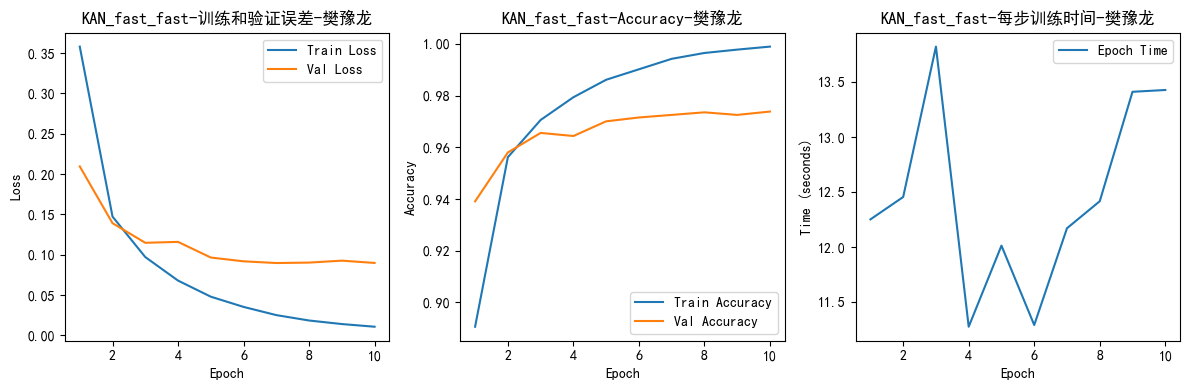

In [19]:
# 绘制损失函数图
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.figure(figsize=(12, 4))
print(train_losses)
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KAN_fast_fast-训练和验证误差-樊豫龙')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('KAN_fast_fast-Accuracy-樊豫龙')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), epoch_times, label='Epoch Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('KAN_fast_fast-每步训练时间-樊豫龙')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
torch.save(model.state_dict(), "./models/kan_fast_fast.pth")